In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler

In [70]:
esmt = pd.read_csv("164928.csv")

In [71]:
esmt.head()

,Location ID,Location Name,Location Group,Location Type,Sensor ID,Place Open,Local Date/Time,UTC Date/Time,# of aggregated records,PM2.5 (μg/m³) raw,...,Temperature (°C) raw,Temperature (°C) corrected,Heat Index (°C),Humidity (%) raw,Humidity (%) corrected,TVOC (ppb),TVOC index,NOX index,PM1 (μg/m³),PM10 (μg/m³)
0,164928,Breath4life,NaN,Outdoor,airgradient:d83bda1d43d8,True,2025-08-08 00:00:00,2025-08-08T00:00:00.000Z,1173,15.4,...,29.9,30.2,37.6,56,78,123,120,1,5.6,18.1
1,164928,Breath4life,NaN,Outdoor,airgradient:d83bda1d43d8,True,2025-08-07 00:00:00,2025-08-07T00:00:00.000Z,1315,7.9,...,30.3,30.6,38.9,57,79,89,91,1,2.7,9.4
2,164928,Breath4life,NaN,Outdoor,airgradient:d83bda1d43d8,True,2025-08-06 00:00:00,2025-08-06T00:00:00.000Z,1348,8.3,...,31.0,31.5,40.7,54,76,121,115,1,3.7,9.3
3,164928,Breath4life,NaN,Outdoor,airgradient:d83bda1d43d8,True,2025-08-05 00:00:00,2025-08-05T00:00:00.000Z,1312,14.2,...,29.8,30.1,37.5,56,78,133,123,1,6.1,16.2
4,164928,Breath4life,NaN,Outdoor,airgradient:d83bda1d43d8,True,2025-08-04 00:00:00,2025-08-04T00:00:00.000Z,1252,13.5,...,30.2,30.6,37.5,53,74,143,135,1,6.0,15.2


In [72]:
esmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Location ID                 18 non-null     int64  
 1   Location Name               18 non-null     object 
 2   Location Group              0 non-null      float64
 3   Location Type               18 non-null     object 
 4   Sensor ID                   18 non-null     object 
 5   Place Open                  18 non-null     bool   
 6   Local Date/Time             18 non-null     object 
 7   UTC Date/Time               18 non-null     object 
 8   # of aggregated records     18 non-null     int64  
 9   PM2.5 (μg/m³) raw           18 non-null     float64
 10  PM2.5 (μg/m³) corrected     18 non-null     float64
 11  0.3μm particle count        18 non-null     int64  
 12  CO2 (ppm) raw               18 non-null     int64  
 13  CO2 (ppm) corrected         18 non-nu

In [73]:
esmt.shape

(18, 24)

In [74]:
df = esmt.copy()

In [75]:
df.isnull().sum()

Location ID                    0
Location Name                  0
Location Group                18
Location Type                  0
Sensor ID                      0
Place Open                     0
Local Date/Time                0
UTC Date/Time                  0
# of aggregated records        0
PM2.5 (μg/m³) raw              0
PM2.5 (μg/m³) corrected        0
0.3μm particle count           0
CO2 (ppm) raw                  0
CO2 (ppm) corrected            0
Temperature (°C) raw           0
Temperature (°C) corrected     0
Heat Index (°C)                0
Humidity (%) raw               0
Humidity (%) corrected         0
TVOC (ppb)                     0
TVOC index                     0
NOX index                      0
PM1 (μg/m³)                    0
PM10 (μg/m³)                   0
dtype: int64

In [76]:
# Supprimer colonnes inutiles
cols_a_supprimer = [
    'Location ID', 'Location Name', 'Location Group', 'Location Type',
    'Sensor ID', 'Place Open', 'UTC Date/Time'
] + [col for col in df.columns if "raw" in col.lower()]  # remove raw

df.drop(columns=cols_a_supprimer, inplace=True, errors='ignore')

In [77]:
df.isnull().sum()

Local Date/Time               0
# of aggregated records       0
PM2.5 (μg/m³) corrected       0
0.3μm particle count          0
CO2 (ppm) corrected           0
Temperature (°C) corrected    0
Heat Index (°C)               0
Humidity (%) corrected        0
TVOC (ppb)                    0
TVOC index                    0
NOX index                     0
PM1 (μg/m³)                   0
PM10 (μg/m³)                  0
dtype: int64

In [78]:
num_cols = df.select_dtypes(include = ["number"]).columns
cat_cols = df.select_dtypes(include = ["object"]).columns 



In [79]:
# Convertir la date en datetime + tri
df['Local Date/Time'] = pd.to_datetime(df['Local Date/Time'])
df.sort_values('Local Date/Time', inplace=True)
df.set_index('Local Date/Time', inplace=True)

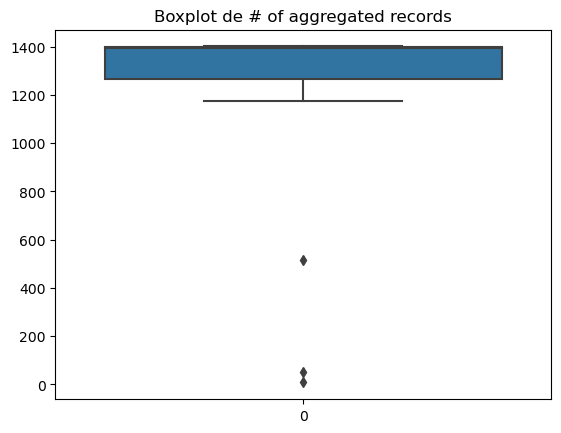

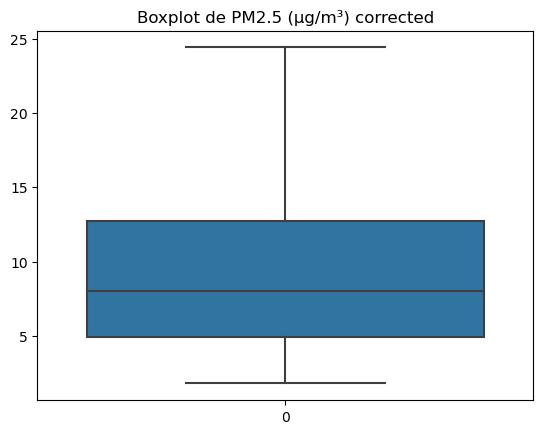

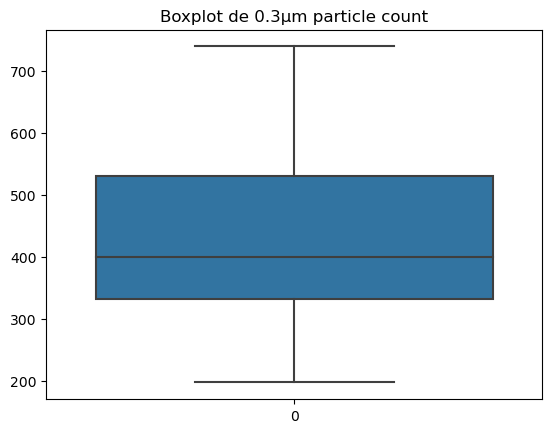

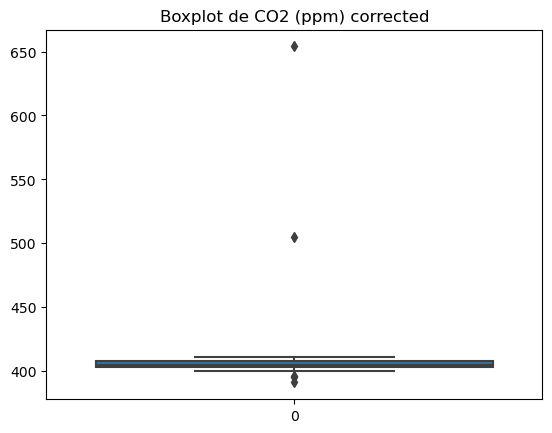

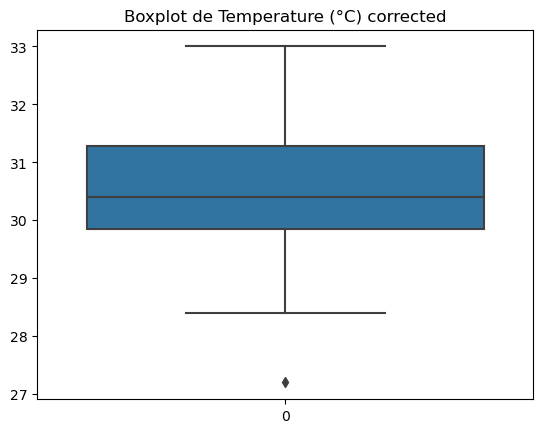

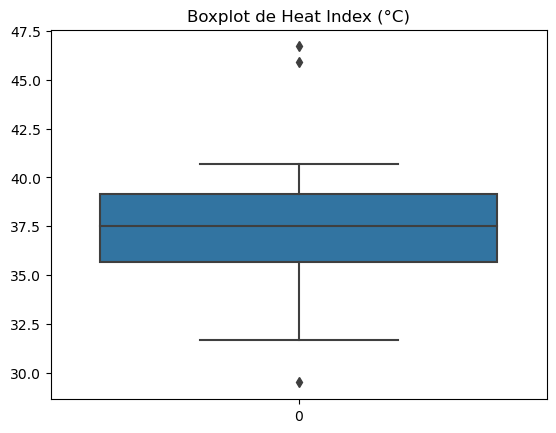

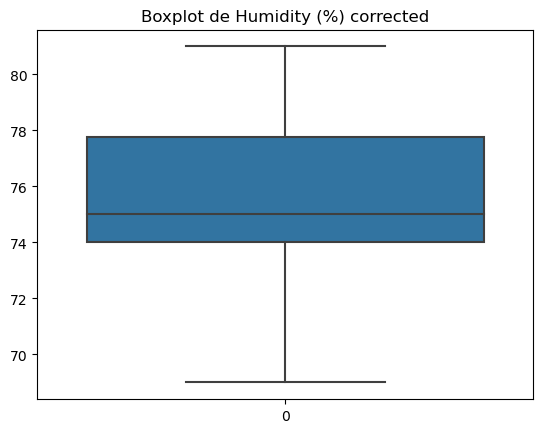

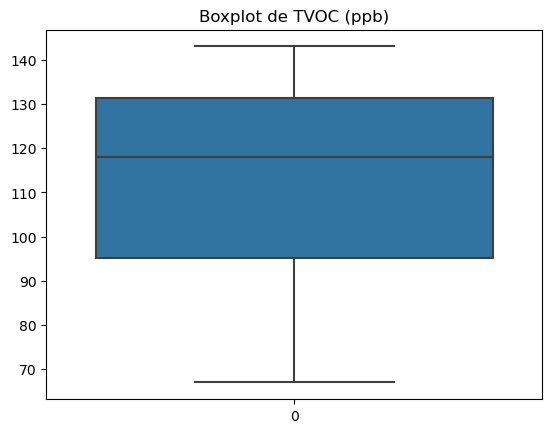

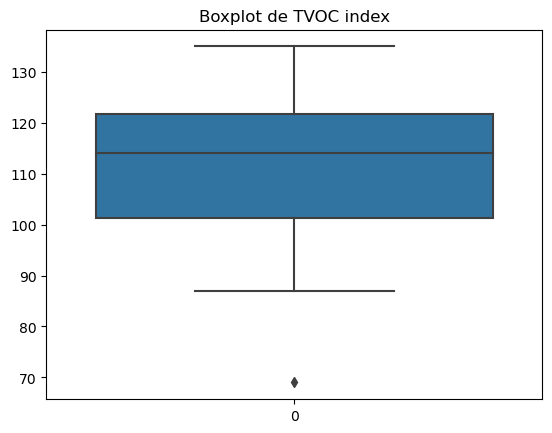

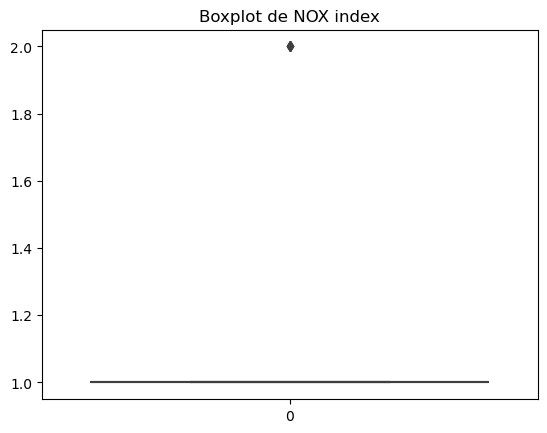

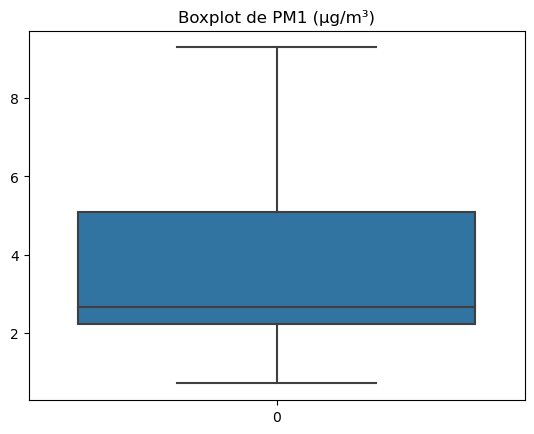

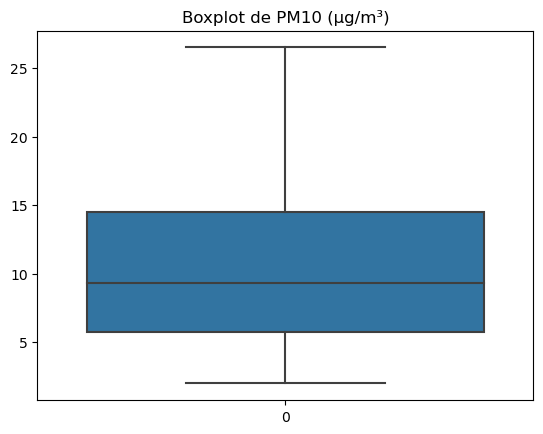

In [80]:
for col in num_cols:
    sns.boxplot(df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

In [83]:
for col in cat_cols:
    if col != "Local Date/Time":
        plt.title(f"Distribution de {col}")
        sns.catplot(x=col, kind="count", data=df)

In [84]:

# === 2. Fenêtrage glissant pour J+1 ===
def create_lag_features(data, target_col, lags=3):
    df_feat = pd.DataFrame(index=data.index)
    for lag in range(1, lags+1):
        df_feat[f"{target_col}_lag{lag}"] = data[target_col].shift(lag)
    df_feat['target'] = data[target_col].shift(-1)  # prédire J+1
    return df_feat.dropna()



=== Modèle pour PM2.5 (μg/m³) corrected ===
RMSE: 3.20, MAE: 3.07, R²: 0.14


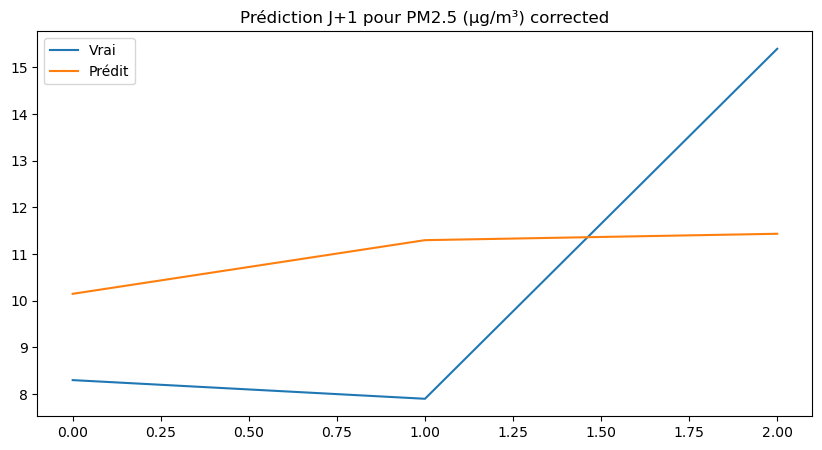


=== Modèle pour CO2 (ppm) corrected ===
RMSE: 3.92, MAE: 2.36, R²: -1.77


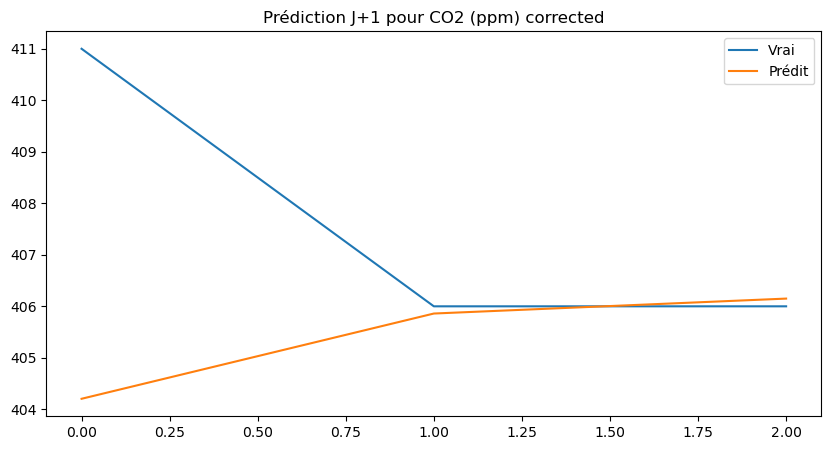


=== Modèle pour TVOC (ppb) ===
RMSE: 15.48, MAE: 11.57, R²: 0.01


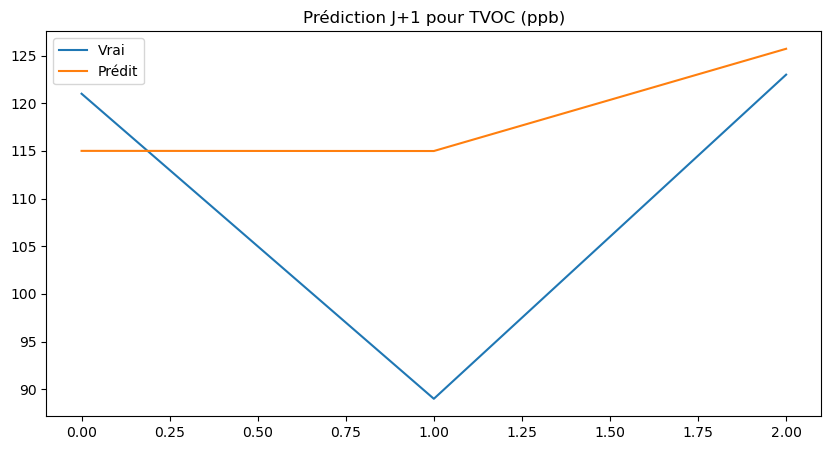


=== Modèle pour TVOC index ===
RMSE: 17.90, MAE: 15.72, R²: -1.00


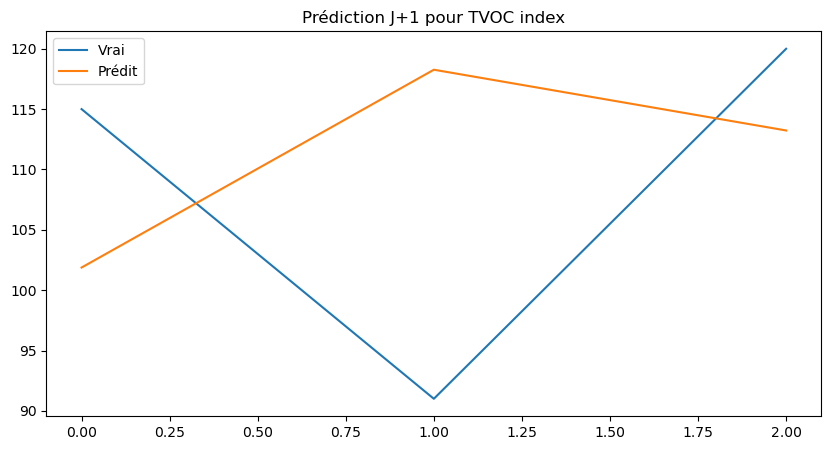


=== Modèle pour NOX index ===
RMSE: 0.62, MAE: 0.62, R²: 0.00


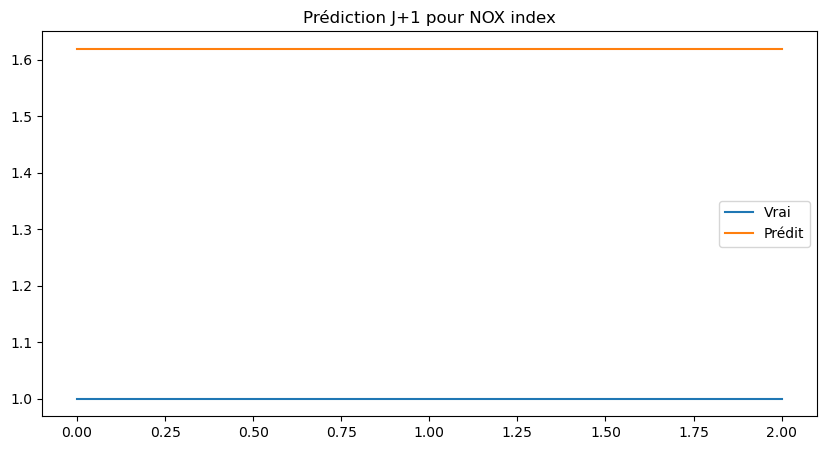


=== Modèle pour PM1 (μg/m³) ===
RMSE: 1.34, MAE: 1.20, R²: -0.24


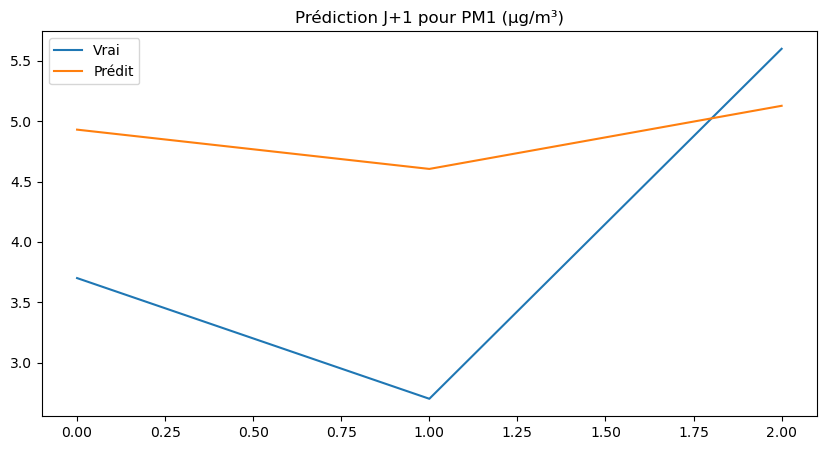


=== Modèle pour PM10 (μg/m³) ===
RMSE: 3.74, MAE: 3.56, R²: 0.18


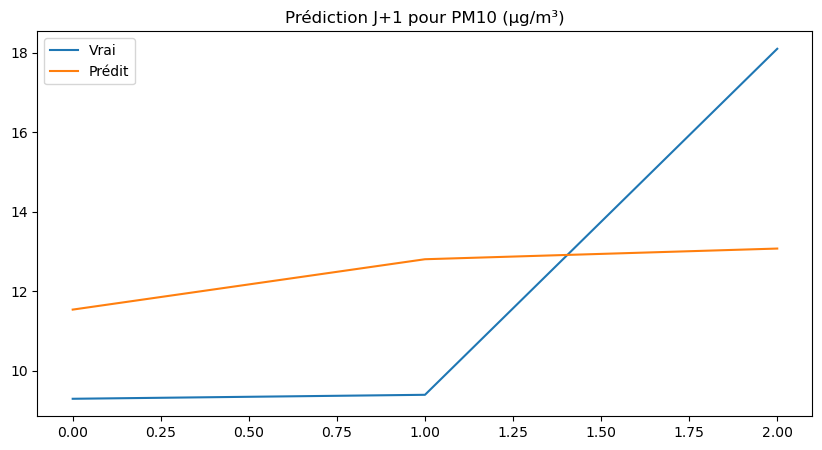


Résumé performances :
PM2.5 (μg/m³) corrected → RMSE: 3.20, MAE: 3.07, R²: 0.14
CO2 (ppm) corrected → RMSE: 3.92, MAE: 2.36, R²: -1.77
TVOC (ppb) → RMSE: 15.48, MAE: 11.57, R²: 0.01
TVOC index → RMSE: 17.90, MAE: 15.72, R²: -1.00
NOX index → RMSE: 0.62, MAE: 0.62, R²: 0.00
PM1 (μg/m³) → RMSE: 1.34, MAE: 1.20, R²: -0.24
PM10 (μg/m³) → RMSE: 3.74, MAE: 3.56, R²: 0.18


In [85]:

# Liste des polluants (corrected uniquement)
polluants = [col for col in df.columns if any(pm in col for pm in ["PM", "CO2", "NO2", "TVOC", "NOX"])]

# === 3. Boucle d'entraînement par polluant ===
results = {}

for pol in polluants:
    print(f"\n=== Modèle pour {pol} ===")
    
    # Créer les features
    data_pol = create_lag_features(df, pol, lags=3)
    
    # Train/test split (80/20)
    train_size = int(len(data_pol) * 0.8)
    train, test = data_pol.iloc[:train_size], data_pol.iloc[train_size:]
    
    X_train, y_train = train.drop(columns='target'), train['target']
    X_test, y_test = test.drop(columns='target'), test['target']
    
    # Normalisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Modèle RandomForest
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Évaluation
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[pol] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    
    # Graphique comparaison
    plt.figure(figsize=(10,5))
    plt.plot(y_test.values, label="Vrai")
    plt.plot(y_pred, label="Prédit")
    plt.title(f"Prédiction J+1 pour {pol}")
    plt.legend()
    plt.show()

# === 4. Résumé des résultats ===
print("\nRésumé performances :")
for pol, metrics in results.items():
    print(f"{pol} → RMSE: {metrics['RMSE']:.2f}, MAE: {metrics['MAE']:.2f}, R²: {metrics['R2']:.2f}")


In [44]:
polluants = [
    'PM2.5 (μg/m³) corrected',
    'PM1 (μg/m³)',
    'PM10 (μg/m³)',
    'CO2 (ppm) corrected',
    'TVOC (ppb)'
]

meteo = ['Temperature (°C) corrected', 'Humidity (%) corrected']

df = df[['Local Date/Time'] + polluants + meteo].dropna()

# 3. Création des features "lag" (J-1)
for col in polluants + meteo:
    df[f'{col}_lag1'] = df[col].shift(1)
    
# Supprimer les lignes avec NaN créés par le décalage
df = df.dropna()


# 4. Définir X (features) et Y (cibles)
X = df[[f'{col}_lag1' for col in polluants + meteo]]
y = df[polluants]


# 5. Split train/test (attention : pas de shuffle pour séries temporelles)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# 6. Modèle multi-sortie
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42))
model.fit(X_train, y_train)



# 7. Prédictions J+1
y_pred = model.predict(X_test)

# 8. Évaluation
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
for col, err in zip(polluants, mae):
    print(f"MAE {col} : {err:.2f}")
    
    
# 9. Exemple de comparaison visuelle pour PM2.5
plt.figure(figsize=(10,5))
plt.plot(y_test['PM2.5 (μg/m³) corrected'].values, label='Vrai')
plt.plot(y_pred[:, 0], label='Prédit')
plt.legend()
plt.title("Prédiction J+1 PM2.5")
plt.show()


# Évaluation

print("MSE :", mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("MAE :", mean_absolute_error(y_test, y_pred, multioutput='raw_values'))
print("R² :", r2_score(y_test, y_pred, multioutput='raw_values'))



In [87]:

!pip install tensorflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 2.1.3 which is incompatible.
scipy 1.11.1 requires numpy<1.28.0,>=1.21.6, but you have numpy 2.1.3 which is incompatible.



  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/3c/e3/e868f1d5951047f950d2ba1e04a765a3328a51f06996b67976d6102f8227/tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/8f/aa/ba0014cc4659328dc818a28827be78e6d97312ab0cb98105a770924dc11e/absl_py-2.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=24.3.25 from https://files.pythonhosted.org/packages/b8/25/155f9f080d5e4bc0082edfda032ea2bc2b8fab3f4d25d46c1e9dd22a1a89/flatbuffers-25.2.10-py2.py3-none-any.whl.metadata
  Obtaining dependency information for gast!=0.5.0,!=0.5.1,!=0.5.2,>=0.2.1 from https://files.pythonhosted.org/packages/a3/61/8001b38461d751

In [88]:
import os
import joblib
import numpy as np
import pandas as pd
from math import sqrt

# ML / DL
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf



ImportError: Traceback (most recent call last):
  File "C:\Users\Rachidi Daouda\anaconda3\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:

# -------------------------------------------
# Réglages reproducibilité (facultatif)
np.random.seed(42)
tf.random.set_seed(42)

# -------------------------------------------
# Paramètres
CSV_PATH = "164928.csv"      # adapte si besoin
MODELS_DIR = "models"
MODEL_FILENAME = os.path.join(MODELS_DIR, "lstm_multivar.h5")
SCALER_FILENAME = os.path.join(MODELS_DIR, "scaler_multivar.pkl")
META_FILENAME = os.path.join(MODELS_DIR, "meta_multivar.pkl")
n_lags = 3                         # fenêtre (tu peux augmenter)
test_ratio = 0.2

os.makedirs(MODELS_DIR, exist_ok=True)

# -------------------------------------------
# 1) Chargement et nettoyage (comme ton code)
df = pd.read_csv(CSV_PATH)

# Supprimer colonnes non utiles (garde ce qui t'intéresse)
cols_a_supprimer = [
    'Location ID', 'Location Name', 'Location Group', 'Location Type',
    'Sensor ID', 'Place Open', 'UTC Date/Time'
] + [col for col in df.columns if "raw" in col.lower()]
df.drop(columns=cols_a_supprimer, inplace=True, errors='ignore')


In [ ]:
# Date -> index temporel
df['Local Date/Time'] = pd.to_datetime(df['Local Date/Time'])
df.sort_values('Local Date/Time', inplace=True)
df.set_index('Local Date/Time', inplace=True)

# Liste des polluants (on identifie par mots-clés ; adapte si besoin)
polluants = [col for col in df.columns if any(k in col for k in ["PM", "CO2", "NO2", "TVOC", "NOX"])]

if len(polluants) == 0:
    raise ValueError("Aucun polluant détecté — vérifie les colonnes du fichier CSV et les keywords.")

# -------------------------------------------

In [ ]:

# 2) Split temporel (déterminer l'index de coupure pour le scaler)
N_rows = len(df)
train_cutoff_row = int(N_rows * (1 - test_ratio))   # nombre de lignes pour train (ex: 80%)

# 3) Scaler FIT uniquement sur train pour éviter fuite
scaler = StandardScaler()
scaler.fit(df[polluants].iloc[:train_cutoff_row].values)   # fit sur les premières lignes (train)
data_scaled = scaler.transform(df[polluants].values)       # transformer TOUT le dataset avec ce scaler

# -------------------------------------------

In [ ]:
# 4) Création séquences multivariées (on retourne aussi les indices des targets pour split propre)
def create_sequences_with_indices(arr, n_lags):
    """
    arr : numpy array shape (N, n_features)
    retourne X (samples, n_lags, n_features), y (samples, n_features), y_indices (index of y in original array)
    """
    X, y, y_idx = [], [], []
    N = arr.shape[0]
    for i in range(n_lags, N - 1):
        X.append(arr[i - n_lags:i])
        y.append(arr[i + 1])       # target = i+1 (J+1)
        y_idx.append(i + 1)
    return np.array(X), np.array(y), np.array(y_idx)

X_all, y_all, y_indices = create_sequences_with_indices(data_scaled, n_lags)

In [ ]:

# 5) Split train/test sur la base des indices temporels (pas de shuffle)
train_mask = (y_indices < train_cutoff_row)
if train_mask.sum() < 3:
    # si très peu de séquences training, avertir l'utilisateur (mais on continue)
    print("⚠️ Très peu de séquences dans le train (", train_mask.sum(), "). Considère augmenter n_lags ou avoir plus de données.")

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_test, y_test = X_all[~train_mask], y_all[~train_mask]

print(f"Sequences totales: {len(X_all)}  | train: {len(X_train)}  | test: {len(X_test)}")

# -------------------------------------------

In [ ]:


# 6) Construire LSTM multivarié (simple, adapté à petits datasets)
n_features = len(polluants)
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(n_lags, n_features), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_features))   # sortie multivariée (un neurone par polluant)
model.compile(optimizer='adam', loss='mse')

# callbacks / training params adaptatifs
patience = 20
es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# validation_split only if enough training samples
val_split = 0.1 if X_train.shape[0] >= 10 else 0.0
batch_size = max(1, min(16, max(1, X_train.shape[0] // 2)))
epochs = 200

history = model.fit(
    X_train, y_train,
    validation_split=val_split,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)

# -------------------------------------------

In [ ]:
# 7) Évaluation sur X_test
if len(X_test) > 0:
    y_pred = model.predict(X_test)
    # revenir dans l'échelle originale
    y_test_inv = scaler.inverse_transform(y_test)
    y_pred_inv = scaler.inverse_transform(y_pred)

    # métriques par polluant
    metrics = {}
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    for i, pol in enumerate(polluants):
        rmse = mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i], squared=False)
        mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
        r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])
        metrics[pol] = {"RMSE": float(rmse), "MAE": float(mae), "R2": float(r2)}
    print("Metrics (test):")
    for pol, m in metrics.items():
        print(f"{pol}: RMSE={m['RMSE']:.3f}, MAE={m['MAE']:.3f}, R2={m['R2']:.3f}")
else:
    print("Aucun échantillon test : impossible d'évaluer (dataset trop petit / split).")

# -------------------------------------------

In [ ]:


# 8) Sauvegarde modèle, scaler et méta (prêt production)
model.save(MODEL_FILENAME)
joblib.dump(scaler, SCALER_FILENAME)
meta = {"polluants": polluants, "n_lags": n_lags}
joblib.dump(meta, META_FILENAME)
print("✅ Modèle, scaler et méta sauvegardés dans:", MODELS_DIR)

# -------------------------------------------

In [ ]:
# 9) Fonction de prédiction J+1 à inclure dans ton dashboard
def predict_next_day(last_days_df, model_path=MODEL_FILENAME, scaler_path=SCALER_FILENAME, meta_path=META_FILENAME):
    """
    last_days_df : DataFrame temporel (index datetime) contenant au moins n_lags lignes
                    avec les colonnes correspondant aux polluants (same names as during training).
    Retour : dictionnaire {polluant: valeur_predite}
    """
    # charger méta, scaler, modèle
    meta = joblib.load(meta_path)
    polluants_local = meta["polluants"]
    n_lags_local = meta["n_lags"]

    # vérifications
    if not all(c in last_days_df.columns for c in polluants_local):
        missing = [c for c in polluants_local if c not in last_days_df.columns]
        raise ValueError(f"Colonnes manquantes dans last_days_df : {missing}")

    if len(last_days_df) < n_lags_local:
        raise ValueError(f"last_days_df doit contenir au moins {n_lags_local} lignes (tu en as {len(last_days_df)})")

    scaler_loaded = joblib.load(scaler_path)
    model_loaded = load_model(model_path)

    # préparer la fenêtre (prendre les dernières n_lags lignes)
    window = last_days_df[polluants_local].iloc[-n_lags_local:].values  # shape (n_lags, n_features)
    window_scaled = scaler_loaded.transform(window)                    # scale using train scaler
    X_input = np.expand_dims(window_scaled, axis=0)                    # shape (1, n_lags, n_features)

    pred_scaled = model_loaded.predict(X_input)                        # shape (1, n_features)
    pred = scaler_loaded.inverse_transform(pred_scaled)[0]             # (n_features,)

    return dict(zip(polluants_local, [float(x) for x in pred]))

# Exemple d'utilisation:
# last_window_df = df[polluants].tail(n_lags)   # df initial chargé plus haut
# pred_j1 = predict_next_day(last_window_df)
# print("Prédiction J+1 :", pred_j1)

# -------------------------------------------
# 10) Variante (pour usage Streamlit) : charger une fois au démarrage
# MODEL = load_model(MODEL_FILENAME)
# SCALER = joblib.load(SCALER_FILENAME)
# META = joblib.load(META_FILENAME)
# puis appeler une fonction qui utilise MODEL/SCALER/META sans reloader à chaque fois.
